In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE_DIR = os.path.dirname(os.path.abspath(''))
DATA_DIR = os.path.join(BASE_DIR, 'data')
DATA_DIR_RAW = os.path.join(DATA_DIR, 'raw')
DATA_DIR_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_DIR_FINAL = os.path.join(DATA_DIR, 'final')

INPUT_CSV_FILENAME = '2019_Net_Generation_PSCO.csv'

In [2]:
input_gen_df = pd.read_csv(os.path.join(DATA_DIR_RAW, INPUT_CSV_FILENAME))

# read_csv grabs a few rows below last row w actual data. drop these rows
input_gen_df = input_gen_df.dropna(how='all')
interim_gen_df = input_gen_df.copy()

In [3]:
DATETIME_COLNAME = 'Date'
LOAD_COLNAME = 'Load'
COAL_COLNAME = 'Coal'
NG_COLNAME = 'Gas'
HYDRO_COLNAME = 'Hydro'
WIND_COLNAME = 'Wind'
SOLAR_COLNAME = 'Solar'

# augmented cols
GEN_COLNAME = 'total_gen'
LOAD_EQ_GEN_COLNAME = 'load_equals_gen'

interim_gen_df[GEN_COLNAME] = interim_gen_df.apply(
    lambda x: 
        x[COAL_COLNAME] 
        + x[NG_COLNAME]
        + x[HYDRO_COLNAME]
        + x[WIND_COLNAME]
        + x[SOLAR_COLNAME]
    , axis = 1
)

interim_gen_df[LOAD_EQ_GEN_COLNAME] = interim_gen_df.apply(
    lambda x:
        True if x[LOAD_COLNAME] == x[GEN_COLNAME] else False
    , axis = 1
)

# seems like rounding errors, altho all occurred on same day
interim_gen_df[interim_gen_df[LOAD_EQ_GEN_COLNAME] == False]

,Date,Load,Coal,Gas,Hydro,Wind,Solar,total_gen,load_equals_gen
2402,4/11/19 2:00,2641.0,745.0,421.0,0.0,1476.0,0.0,2642.0,False
2408,4/11/19 8:00,3367.0,785.0,659.0,0.0,1900.0,24.0,3368.0,False
2409,4/11/19 9:00,3435.0,792.0,557.0,0.0,1929.0,158.0,3436.0,False
2423,4/11/19 23:00,2909.0,978.0,927.0,3.0,1000.0,0.0,2908.0,False


In [4]:
TOTAL_VRE_COLNAME = 'vre'
interim_gen_df[TOTAL_VRE_COLNAME] = interim_gen_df.apply(
    lambda x: x[SOLAR_COLNAME] + x[WIND_COLNAME],
    axis = 1
)


### Question 1
* Find total, max, min of Load
* Find total, %, max, min, and capacity factor for each gen source
* Find total, %, max, min, and capacity factor for VRE (wind + solar)

In [5]:
def format_large_num(value):
    return f'{value:,}'

print("Total: {}".format(format_large_num(int(interim_gen_df[LOAD_COLNAME].sum()))))
print("Max: {}".format(format_large_num(int(interim_gen_df[LOAD_COLNAME].max()))))
print("Min: {}".format(format_large_num(int(interim_gen_df[LOAD_COLNAME].min()))))

Total: 37,316,375
Max: 7,473
Min: 2,144


In [6]:
df_sums = interim_gen_df.sum()

for col in [COAL_COLNAME, NG_COLNAME, HYDRO_COLNAME, WIND_COLNAME, SOLAR_COLNAME, TOTAL_VRE_COLNAME]:
    total_mwh = df_sums[col]
    perc_total = float(df_sums[col]) / float(df_sums[LOAD_COLNAME])
    max_mw = interim_gen_df[col].max()
    min_mw = interim_gen_df[col].min()
    
    print("****{}".format(col))
    print(" total: {}".format(format_large_num(total_mwh)))
    print(" perc: {}".format(perc_total))
    print(" max: {}".format(max_mw))
    print(" min: {}".format(min_mw))

****Coal
 total: 17,976,864.0
 perc: 0.4817419698456777
 max: 3235.0
 min: 581.0
****Gas
 total: 10,188,766.0
 perc: 0.2730373998010257
 max: 4166.0
 min: 114.0
****Hydro
 total: 308,978.0
 perc: 0.008279957525349126
 max: 829.0
 min: 0.0
****Wind
 total: 7,914,649.0
 perc: 0.2120958694406946
 max: 3068.0
 min: 0.0
****Solar
 total: 927,120.0
 perc: 0.024844856983026888
 max: 404.0
 min: 0.0
****vre
 total: 8,841,769.0
 perc: 0.2369407264237215
 max: 3069.0
 min: 0.0


In [7]:
wind_perc = interim_gen_df[WIND_COLNAME].sum() / interim_gen_df[LOAD_COLNAME].sum()
pv_perc = interim_gen_df[SOLAR_COLNAME].sum() / interim_gen_df[LOAD_COLNAME].sum()

vre_capacity_factor_denominator = \
    wind_perc + pv_perc
    
perc_vre_wind = wind_perc / vre_capacity_factor_denominator
perc_vre_solar = pv_perc / vre_capacity_factor_denominator

# from https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_6_07_b
WIND_CAPACITY_FACTOR = .343 
SOLAR_CAPACITY_FACTOR = .243

vre_capacity_factor = \
    (WIND_CAPACITY_FACTOR * perc_vre_wind) \
    + (SOLAR_CAPACITY_FACTOR * perc_vre_solar)

In [8]:
vre_capacity_factor

0.33251431551763005

### Question 2
* Create an additional column in your data file and calculate % VRE of the total load. Where % VRE = VRE (MW) / Load (MW) for each hour.

In [9]:
PERC_VRE_COLNAME = 'perc_vre'
interim_gen_df[PERC_VRE_COLNAME] = interim_gen_df.apply(
    lambda x: (x[SOLAR_COLNAME] + x[WIND_COLNAME]) / x[LOAD_COLNAME],
    axis = 1 # apply function across rows (axis = 1) instead of columns (axis = 0)
)

In [10]:
interim_gen_df[[DATETIME_COLNAME, LOAD_COLNAME, SOLAR_COLNAME, WIND_COLNAME, TOTAL_VRE_COLNAME, PERC_VRE_COLNAME]] 

,Date,Load,Solar,Wind,vre,perc_vre
0,1/1/19 0:00,4234.0,0.0,1429.0,1429.0,0.337506
1,1/1/19 1:00,3983.0,0.0,1062.0,1062.0,0.266633
2,1/1/19 2:00,3844.0,0.0,788.0,788.0,0.204995
3,1/1/19 3:00,3753.0,0.0,641.0,641.0,0.170797
4,1/1/19 4:00,3725.0,0.0,438.0,438.0,0.117584
...,...,...,...,...,...,...
8755,12/31/19 19:00,6070.0,0.0,1700.0,1700.0,0.280066
8756,12/31/19 20:00,5921.0,0.0,2063.0,2063.0,0.348421
8757,12/31/19 21:00,5627.0,0.0,2050.0,2050.0,0.364315
8758,12/31/19 22:00,5460.0,0.0,1748.0,1748.0,0.320147


### Question 3: 
Graph the % VRE for every hour from January to December in chronological order.

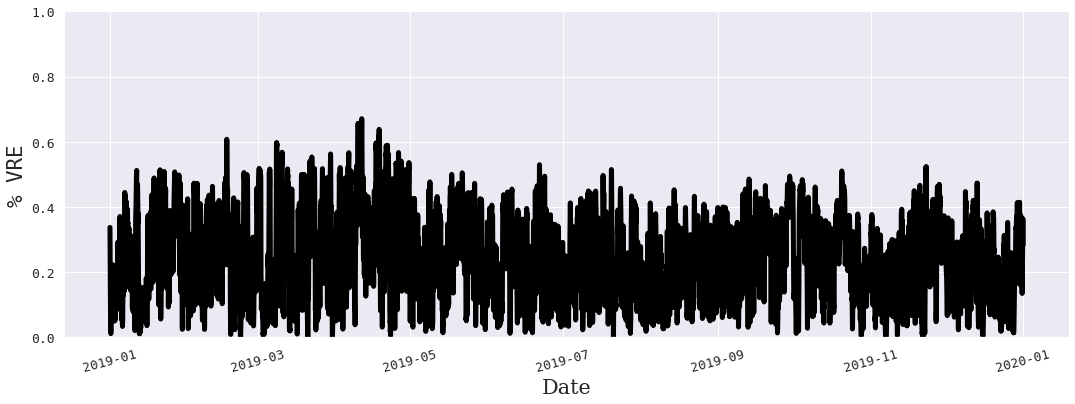

In [54]:
interim_gen_df[DATETIME_COLNAME] = pd.to_datetime(interim_gen_df[DATETIME_COLNAME])

sns.set(rc={'figure.figsize':(18, 6)})
plt.rc('legend',fontsize=16) 

fig = plt.figure()
line_chart = fig.add_subplot(1, 1, 1) 
plt.plot(DATETIME_COLNAME, PERC_VRE_COLNAME, label="% VRE", data=interim_gen_df, linewidth=5,color="black")
plt.ylabel("% VRE", family='monospace' ,fontsize="xx-large")
plt.xlabel("Date", family='serif', fontsize="xx-large")
plt.xticks(fontsize=13, family='monospace', rotation = 15 ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
plt.yticks(fontsize=13, family='monospace' )
plt.ylim(ymin=0, ymax = 1)
plt.show()

### Question 4
Resort the % VRE data from High to Low and plot a % VRE duration curve (similar to the load duration curve)

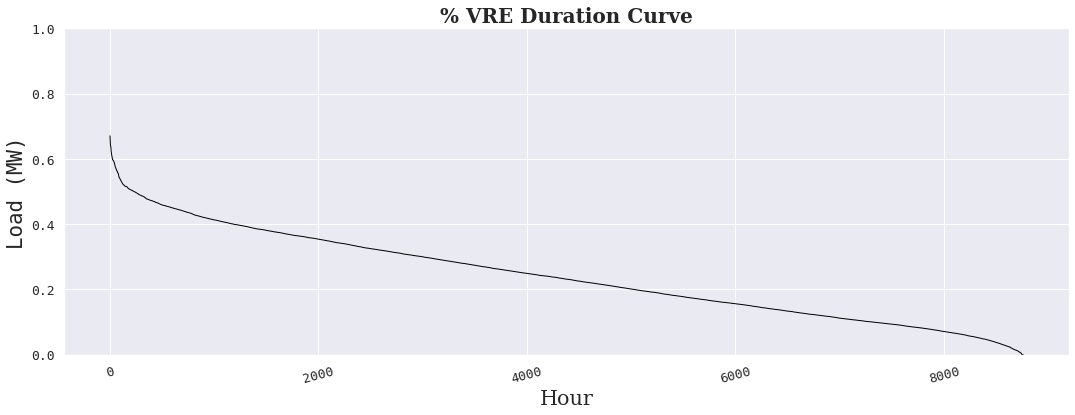

In [58]:
ldc_df = interim_gen_df.sort_values(PERC_VRE_COLNAME, ascending=False).reset_index(drop=True)
ldc_df['index'] = ldc_df.index.values

fig = plt.figure()
load_df_subplot_ax = fig.add_subplot(1, 1, 1)    
    
plt.plot(
    'index', PERC_VRE_COLNAME, label="LDC", data=ldc_df, linewidth=1,color="black")
#load_df_subplot_ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m'))
plt.ylabel("Load (MW)", family='monospace' ,fontsize="xx-large")
plt.xlabel("Hour", family='serif', fontsize="xx-large")
plt.xticks(fontsize=13, family='monospace', rotation = 15 ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
plt.yticks(fontsize=13, family='monospace' )
plt.ylim(ymin=0, ymax = 1)
plt.title("% VRE Duration Curve", family='serif', fontdict={"fontweight": "bold", "size": 20})
plt.show()

In [56]:
vre_dc_df = interim_gen_df.sort_values(PERC_VRE_COLNAME, ascending=False).reset_index(drop=True)
vre_dc_df['index'] = vre_dc_df.index.values

vre_dc_factored_df = interim_gen_df

fig = plt.figure()
load_df_subplot_ax = fig.add_subplot(1, 1, 1)    
    
plt.plot(
    'index', PERC_VRE_COLNAME, label="LDC", data=ldc_df, linewidth=1,color="black")
#load_df_subplot_ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m'))
plt.ylabel("Load (MW)", family='monospace' ,fontsize="xx-large")
plt.xlabel("Hour", family='serif', fontsize="xx-large")
plt.xticks(fontsize=13, family='monospace', rotation = 15 ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
plt.yticks(fontsize=13, family='monospace' )
plt.ylim(ymin=0, ymax = 1)
plt.title("% VRE Duration Curve", family='serif', fontdict={"fontweight": "bold", "size": 20})
plt.show()

,Date,Load,Coal,Gas,Hydro,Wind,Solar,total_gen,load_equals_gen,vre,perc_vre,Wind_factored,Solar_factored,vre_factored,index
0,2019-08-20 18:00:00,7473.0,3055.0,2839.0,119.0,1260.0,200.0,7473.0,True,1460.0,0.195370,3069.093872,3699.504950,6768.598823,0
1,2019-08-06 18:00:00,7280.0,3097.0,3398.0,108.0,497.0,180.0,7280.0,True,677.0,0.092995,1210.587027,3329.554455,4540.141483,1
2,2019-08-20 17:00:00,7199.0,3062.0,2725.0,130.0,958.0,324.0,7199.0,True,1282.0,0.178080,2333.485658,5993.198020,8326.683678,2
3,2019-08-06 17:00:00,7196.0,3079.0,3520.0,98.0,248.0,251.0,7196.0,True,499.0,0.069344,604.075619,4642.878713,5246.954332,3
4,2019-08-06 19:00:00,7131.0,3119.0,2813.0,105.0,1016.0,78.0,7131.0,True,1094.0,0.153415,2474.761408,1442.806931,3917.568339,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019-04-06 16:00:00,2273.0,1364.0,479.0,83.0,133.0,214.0,2273.0,True,347.0,0.152662,323.959909,214.000000,537.959909,8755
8756,2019-04-08 02:00:00,2267.0,1122.0,253.0,0.0,892.0,0.0,2267.0,True,892.0,0.393472,2172.723598,0.000000,2172.723598,8756
8757,2019-05-14 04:00:00,2257.0,1690.0,472.0,0.0,95.0,0.0,2257.0,True,95.0,0.042091,231.399935,0.000000,231.399935,8757
8758,2019-04-08 03:00:00,2160.0,1125.0,249.0,0.0,785.0,1.0,2160.0,True,786.0,0.363889,1912.094198,18.497525,1930.591723,8758


### Question 5
Using the values in the Table from Problem 1, calculate the following (round to 2 decimal places):

In [59]:
wind_peak_ratio = interim_gen_df[LOAD_COLNAME].max() / interim_gen_df[WIND_COLNAME].max()
solar_peak_ratio = interim_gen_df[LOAD_COLNAME].max() / interim_gen_df[SOLAR_COLNAME].max()
print("Peak Load / Peak Wind: {}".format(round(wind_peak_ratio, 2)))
print("Peak Load / Peak Solar: {}".format(round(solar_peak_ratio, 2)))

Peak Load / Peak Wind: 2.44
Peak Load / Peak Solar: 18.5


In [89]:
WIND_FACTORED_COLNAME = f'{WIND_COLNAME}_factored'
SOLAR_FACTORED_COLNAME = f'{SOLAR_COLNAME}_factored'
VRE_FACTORED_COLNAME = f'{TOTAL_VRE_COLNAME}_factored'

In [90]:
interim_gen_df[WIND_FACTORED_COLNAME] = interim_gen_df[WIND_COLNAME] * wind_peak_ratio
interim_gen_df[SOLAR_FACTORED_COLNAME] = interim_gen_df[SOLAR_COLNAME] * solar_peak_ratio

# interim_gen_df[WIND_FACTORED_COLNAME] = interim_gen_df.apply(
#     lambda x: x[WIND_COLNAME] * wind_peak_ratio 
#         if x[WIND_COLNAME] * wind_peak_ratio < x[LOAD_COLNAME]
#         else x[LOAD_COLNAME]
#     , axis = 1
# ) 

# interim_gen_df[SOLAR_FACTORED_COLNAME] = interim_gen_df.apply(
#     lambda x: x[SOLAR_COLNAME] * solar_peak_ratio 
#         if x[SOLAR_COLNAME] * solar_peak_ratio < x[LOAD_COLNAME]
#         else x[SOLAR_COLNAME]
#     , axis = 1
# ) 

interim_gen_df[VRE_FACTORED_COLNAME] = interim_gen_df[WIND_FACTORED_COLNAME] + interim_gen_df[SOLAR_FACTORED_COLNAME]

In [91]:
interim_gen_df[[DATETIME_COLNAME, WIND_FACTORED_COLNAME, VRE_FACTORED_COLNAME]]

,Date,Wind_factored,vre_factored
0,2019-01-01 00:00:00,3480.742177,3480.742177
1,2019-01-01 01:00:00,2586.807692,2586.807692
2,2019-01-01 02:00:00,1919.401565,1919.401565
3,2019-01-01 03:00:00,1561.340613,1561.340613
4,2019-01-01 04:00:00,1066.875489,1066.875489
...,...,...,...
8755,2019-12-31 19:00:00,4140.840939,4140.840939
8756,2019-12-31 20:00:00,5025.032269,5025.032269
8757,2019-12-31 21:00:00,4993.367014,4993.367014
8758,2019-12-31 22:00:00,4257.758801,4257.758801


### Question 7
What is the annual total MWh produced from wind and solar at these new values?
And what percent of the total annual load do they cover?

In [68]:
format_large_num(round(interim_gen_df[VRE_FACTORED_COLNAME].sum(), 2))

'36,427,838.44'

In [69]:
interim_gen_df[VRE_FACTORED_COLNAME].sum() / interim_gen_df[LOAD_COLNAME].sum()

0.9761890976704988

In [70]:
len(interim_gen_df[interim_gen_df[VRE_FACTORED_COLNAME] > interim_gen_df[LOAD_COLNAME]])

3626

### Question 8 
Resort the data from high to low creating a new % VRE duration curve and graph on top of the curve in Item #4

In [76]:
vre_dc_df = interim_gen_df.sort_values(PERC_VRE_COLNAME, ascending=False).reset_index(drop=True)
vre_dc_df['index'] = vre_dc_df.index.values

PERC_VRE_FACTORED_COLNAME = f'{PERC_VRE_COLNAME}_factored'
interim_gen_df[PERC_VRE_FACTORED_COLNAME] = interim_gen_df[VRE_FACTORED_COLNAME] / interim_gen_df[LOAD_COLNAME]
vre_dc_factored_df = interim_gen_df.sort_values(PERC_VRE_FACTORED_COLNAME, ascending=False).reset_index(drop=True)
vre_dc_factored_df['index'] = vre_dc_factored_df.index.values

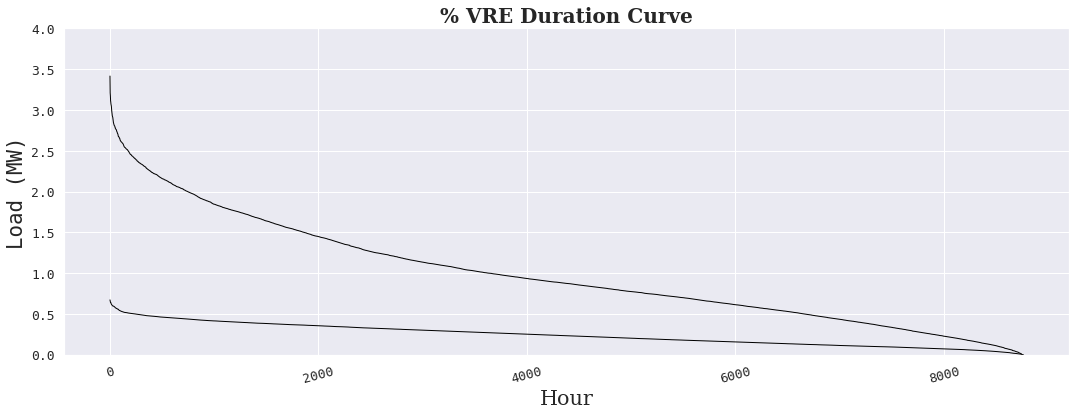

In [81]:
fig = plt.figure()
vre_perc_dc_subplot_ax = fig.add_subplot(1, 1, 1)    
    
plt.plot(
    'index', PERC_VRE_COLNAME, label="% VRE", data=vre_dc_df, linewidth=1,color="black"
)

plt.plot(
    'index', PERC_VRE_FACTORED_COLNAME, label="% VRE (Factored)", data=vre_dc_factored_df, linewidth=1,color="black"
)
#load_df_subplot_ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m'))
plt.ylabel("Load (MW)", family='monospace' ,fontsize="xx-large")
plt.xlabel("Hour", family='serif', fontsize="xx-large")
plt.xticks(fontsize=13, family='monospace', rotation = 15 ) # Rotate ticks. Doesn't look great, imo: rotation = 15, ha='right'
plt.yticks(fontsize=13, family='monospace' )
plt.ylim(ymin=0, ymax = 4)
plt.title("% VRE Duration Curve", family='serif', fontdict={"fontweight": "bold", "size": 20})
plt.show()

### Question 9
How many hours during the year was the % VRE = 0?

In [82]:
len(interim_gen_df[interim_gen_df[TOTAL_VRE_COLNAME] == 0])

12

### Question 10
Determine the general amount of land per MW required by a wind and solar plant.  Calculate the total land use based on the new peak generation for wind and solar that was multiplied by the increase factor. This would give you the land requirements for installing that amount of wind and solar.

In [86]:
wind_km2_per_mw = 0.25
solar_km2_per_mw = 0.0202343

interim_gen_df[SOLAR_FACTORED_COLNAME].max() * solar_km2_per_mw

151.2109239

In [94]:
interim_gen_df[WIND_FACTORED_COLNAME].max() * wind_km2_per_mw

1868.25

### Question 12
What percent of the land area of Colorado is needed for the solar and wind?

In [99]:
CO_LAND_AREA_KM2 = 269838

print("% land of CO needed to meet peak solar (factored): {}".format(
    (interim_gen_df[SOLAR_FACTORED_COLNAME].max() * solar_km2_per_mw) / CO_LAND_AREA_KM2)
)

print("% land of CO needed to meet peak wind (factored): {}".format(
    (interim_gen_df[WIND_FACTORED_COLNAME].max() * wind_km2_per_mw) / CO_LAND_AREA_KM2)
)

% land of CO needed to meet peak solar (factored): 0.0005603766848998288
% land of CO needed to meet peak wind (factored): 0.006923598603606609
